# Road to Paris 2024

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


%matplotlib inline
%config InlineBackend.figure_format = 'jpg'
sns.set_theme()

df=pd.read_csv('./PycharmProjects/medium/scripts/Paris2024.csv').rename(columns={'Date ':'Date'})
df['Date']=pd.to_datetime(df.Date,format='%d/%m/%Y')
df['Team']=df.apply(lambda x: x['Player 1'].split(" ")[-1] +"/" + x['Player 2'].split(" ")[-1],axis=1)
df['Events']=df.apply(lambda x: int(x.Points.split('(')[1].replace(")",'')) ,axis=1)
df['Points']=df.apply(lambda x: int(x.Points.split()[0]) ,axis=1)
df['Points/Event']=df['Points']/df['Events']
df.loc[df['Events']<3,'Points/Event']=np.nan
last_date=df.Date.unique()[-1]
total=df[df.Date==last_date][['Team','Points']].rename(columns={'Points':'Total'})
df=df.merge(total,on='Team',how='left')

In [14]:
def plot_ranks(df,gender='male',inlet=False):
    colors=['r','g','b','k','m','y','c','tab:orange','tab:brown','tab:gray','lime','deeppink','teal','deepskyblue','olive','maroon','sandybrown','violet']
    markers=['o','^','v','s','*']
    show_rank=17
    fix, axs= plt.subplots(ncols=1,nrows=1,sharey=True,figsize=(24,10))

    if inlet:
        axin = axs.inset_axes([0.85, 0.1, 0.1, 0.4])
    c=0
    m=0
    quota={}
    #2023_FIVB_BVB_Sport%20Operations%20Manual_Mark-up%20.pdf
    elite_points=[('Last',360),('17th',400),('13th',230*2),('9th',300*2),
                  ('5th',380*2),('4th',450*2),('3rd',500*2),('2nd',550*2),
                  ('1st',600*2)]
    tmp_df=df[df.Gender==gender].copy().sort_values(by=['Date','Total'],ascending=[True,False]).copy()
    rank=tmp_df[tmp_df.Date==last_date].reset_index(drop=True)['Team'].reset_index().rename(columns={'index':'Rank'})
    tmp_df=tmp_df.merge(rank,on='Team',how='left')
    tmp_df['Rank']=tmp_df['Rank']+1
    tmp_df['pts_events']=np.nan
    pts_ave_th=2
    ymin=np.inf
    ymax=-np.inf
    for rank,row in tmp_df.groupby('Rank'):
        #print("****Row=%s"%row)
        row['dx']=row.Points.diff()
        row['dx']=row['dx'].replace(0,np.nan)
        pts_events=np.r_[row['Points'].values[0],row.loc[row.dx.notna(),'dx'].values]
        pts_events_ave=np.mean(pts_events[-3:]) if len(pts_events)>pts_ave_th else np.nan
        tmp_df.loc[tmp_df.Rank==rank,'pts_events']=pts_events_ave
        if rank>show_rank:
            break
        alpha= 0.5 if rank<show_rank else 0.1
        country=row.Country.values[0]
        line_style='solid'
        marker=markers[m]
        label='%.0f'%rank +' ' + row.Team.values[0] +' ' + row.Country.values[0]
        if country in quota:
            if quota[country]==2:
                line_style='dashed'
                marker='none'
                show_rank=show_rank+1
                label=label +  ' (out, quota)'
            else:
                quota[country]=quota[country]+1
        else:
            quota[country]=1


        row.plot(x='Date',y='Points',ax=axs,alpha=alpha,marker=marker,color=colors[c],label=label,
                 linewidth=4,markersize=10,linestyle=line_style)
        if rank<=5 and inlet:
            row.iloc[-2:,:].plot(x='Date',y='Points',ax=axin,alpha=alpha,marker=marker,color=colors[c],
                     linewidth=4,markersize=10,linestyle=line_style)
        if row.iloc[-1:,:].Points.min()<ymin:
            ymin=row.iloc[-1:,:].Points.min()
        if row.iloc[-2:,:].Points.max()>ymax:
            ymax=row.iloc[-2:,:].Points.max()

        if (c+1)==len(colors):
            m+=1
            m = m+1 if (m+1)<len(markers) else 0
        c = c+1 if (c+1)<len(colors) else 0
    plt.axhline(y=7200, color='k', linestyle='-',linewidth=4)
    plt.text(df.Date.unique()[-3], 7300, 'Projected cut line', fontsize=12)

    #Plot relevant events
    for event in [('Elite16\nOstrava','31/05/2023'),('Elite16\nGstaad','04/07/2023'),('Elite16\nMontreal','26/07/2023'),
                  ('Elite16\nHamburg','16/08/2023'),('Elite16\nParis','27/09/2023'),('Worlds\nTlaxcala','06/10/2023'),
                  ('Elite 16\nJoao Pessoa','26/11/2023')]:
        event_dt=pd.to_datetime(event[1],format='%d/%m/%Y')
        plt.axvline(x=event_dt, ymin=0,ymax=100, color='b', linestyle=':',linewidth=4,alpha=0.5)
        plt.text(event_dt, 1300, event[0], fontsize=12)

    #axs.legend(loc='lower left')
    axs.legend(loc='upper right')
    #axs.set_ylim(3000,10000)
    axs.set_xlim(pd.to_datetime('1/3/2023',format='%d/%m/%Y'),pd.to_datetime('28/2/2024',format='%d/%m/%Y'))
    axs.set_ylabel('2024 Olympic Points')

    if inlet:
        axin.set_xlim(pd.to_datetime('15/9/2023',format='%d/%m/%Y'),pd.to_datetime('20/12/2023',format='%d/%m/%Y'))
        #axin.set_ylim(ymin-100,ymax+200)
        axin.set_ylim(ymax-2500,ymax+200)
        axin.get_legend().remove()
        axin.get_xaxis().set_ticks([])
        axin.get_yaxis().set_ticks([])
        axin.set_xlabel('')
        axs.indicate_inset_zoom(axin)


    plt.figure(figsize=(15,8))
    #Plot Points per Event
    fix, axs= plt.subplots(ncols=1,nrows=1,sharey=True,figsize=(24,10))
    stats=tmp_df.drop_duplicates(subset=['Team'],keep='last')
    #stats=stats.dropna(subset=['pts_events']).sort_values(by=['pts_events'],ascending=False)
    stats=stats.dropna(subset=['Points/Event']).sort_values(by=['Points/Event'],ascending=False)

    #sns.barplot(x="pts_events", y="Team", data=stats, label="Points per last 3 events",orient='h',color='steelblue')
    sns.barplot(x="Points/Event", y="Team", data=stats, orient='h',color='steelblue')
    for e in elite_points:
        plt.axvline(x=e[1], color='k', linestyle='-',linewidth=4)
        plt.text(e[1]+10, 1, e[0], fontsize=12)
    axs.set_xlim(350,1250)


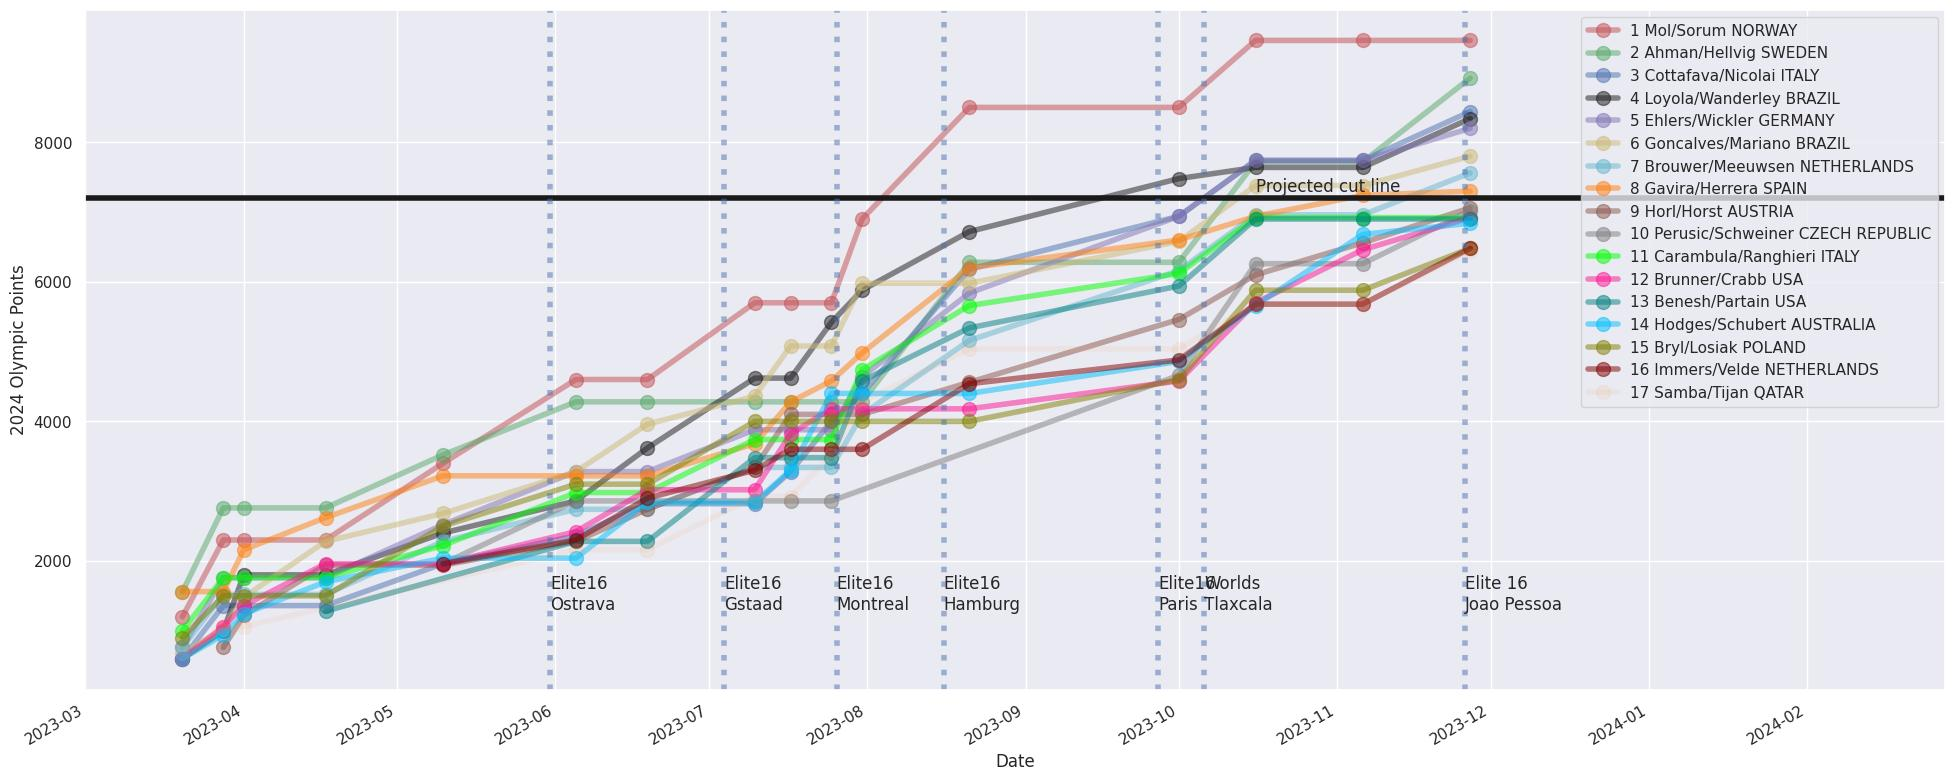

<Figure size 1500x800 with 0 Axes>

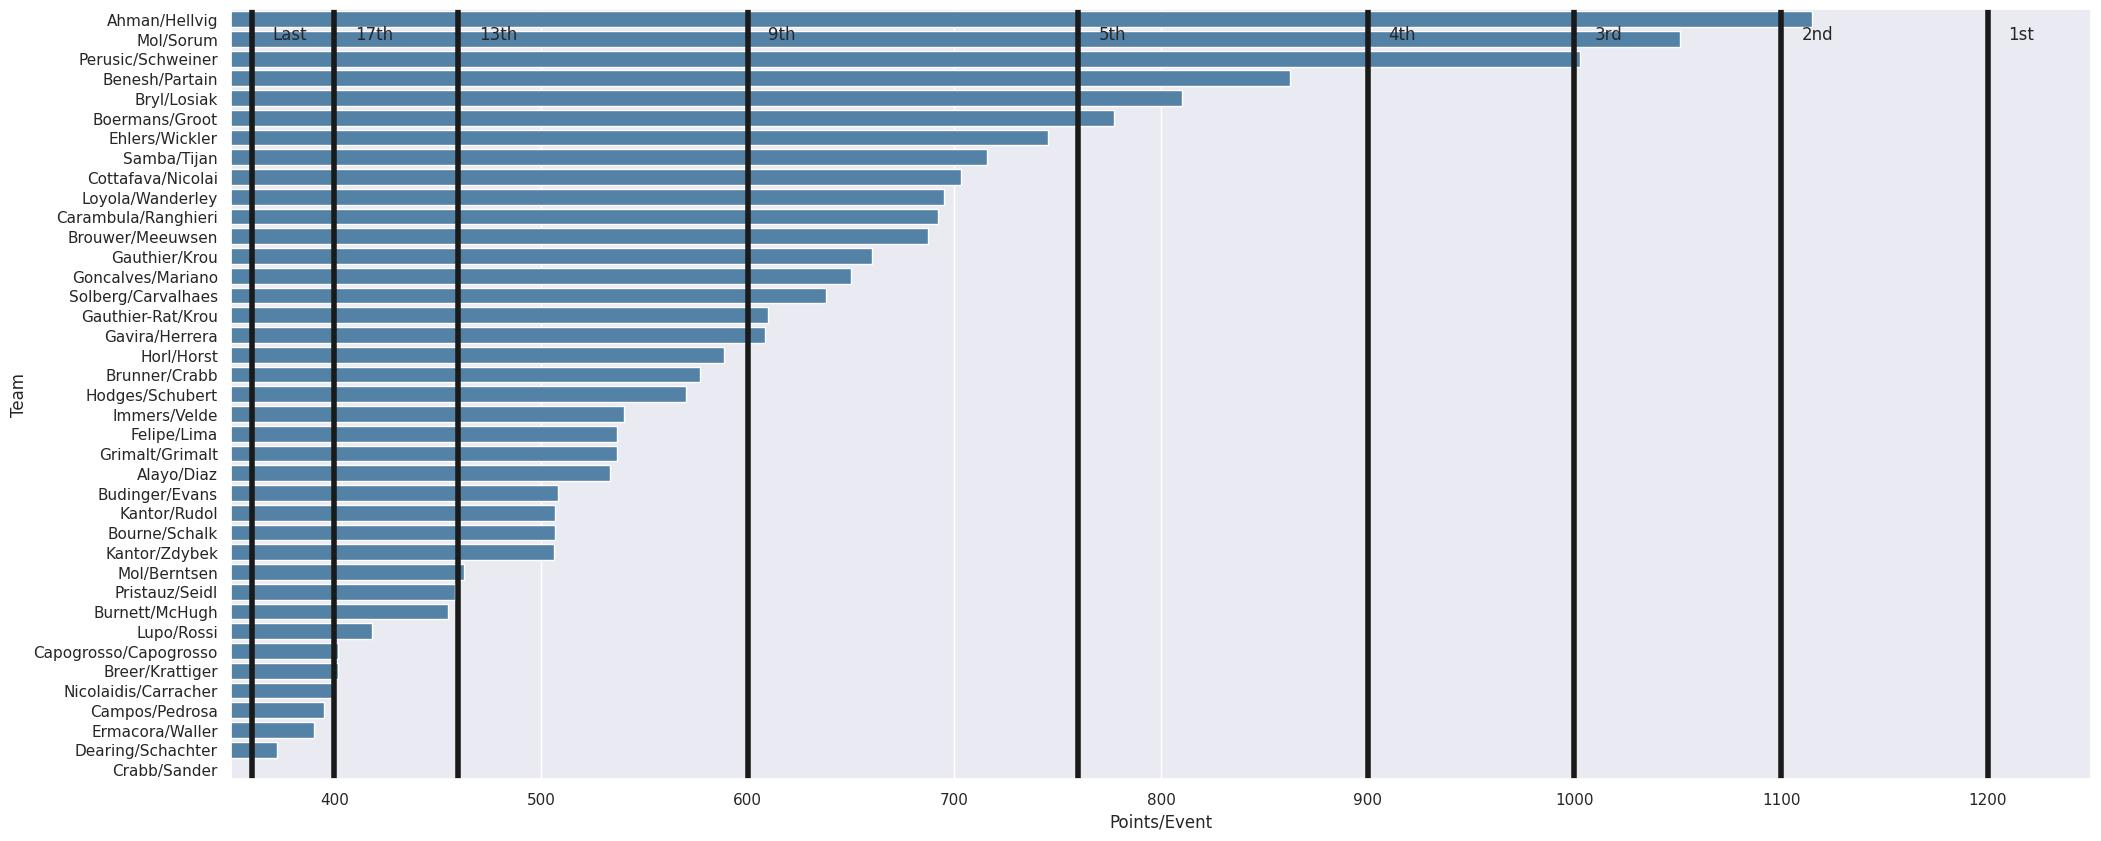

In [15]:
stats=plot_ranks(df,gender='male')

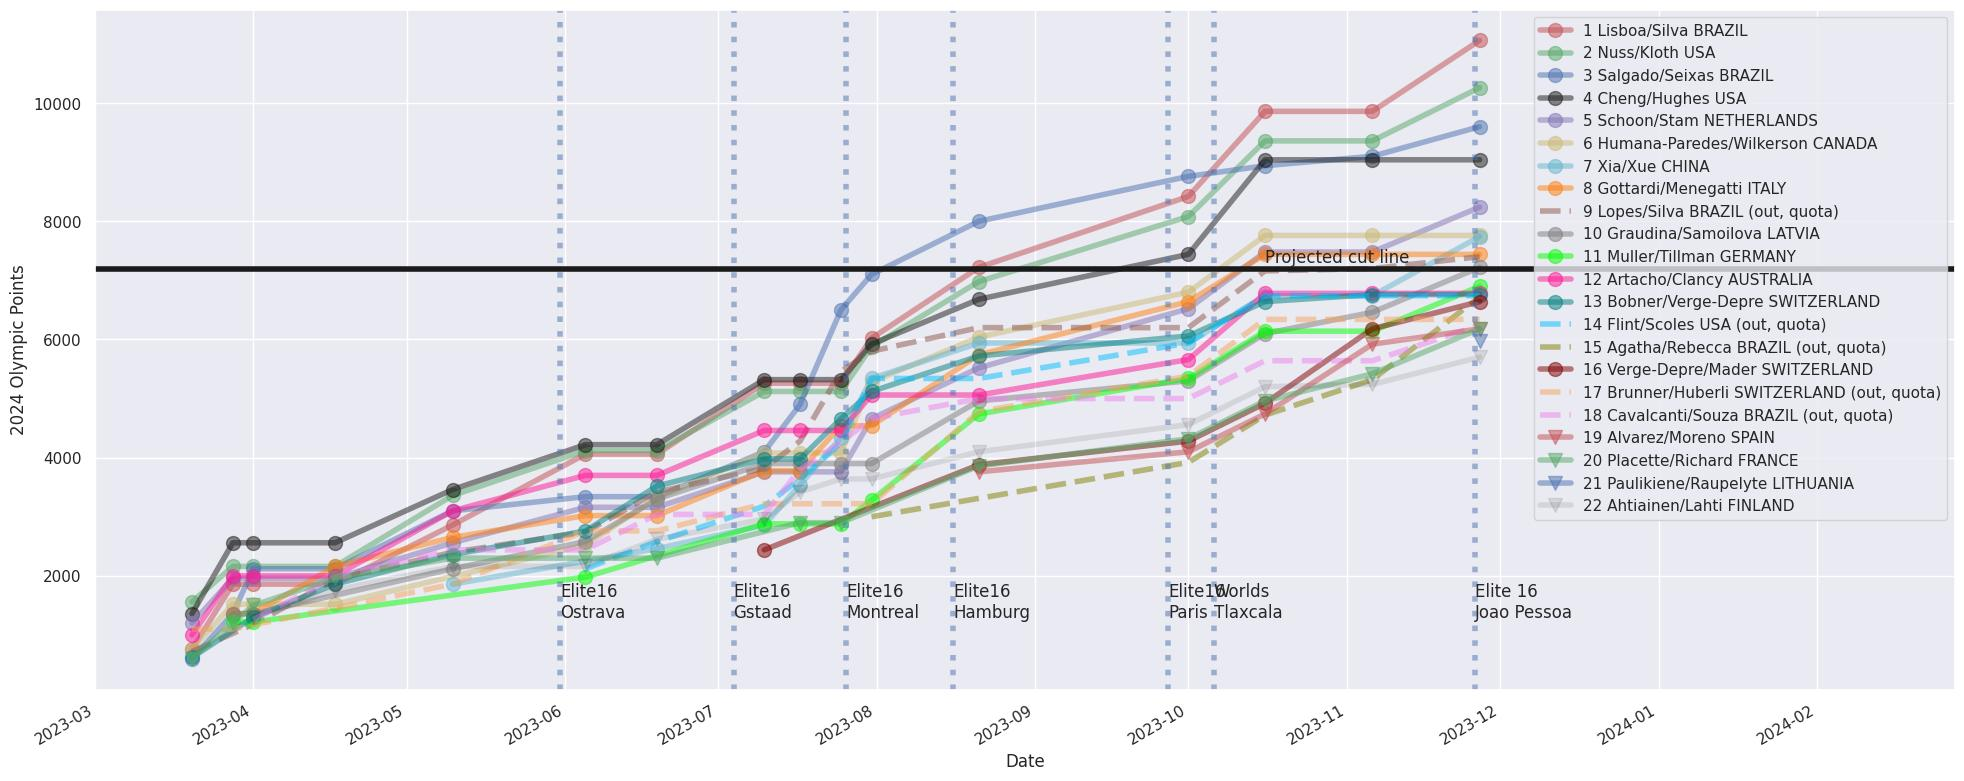

<Figure size 1500x800 with 0 Axes>

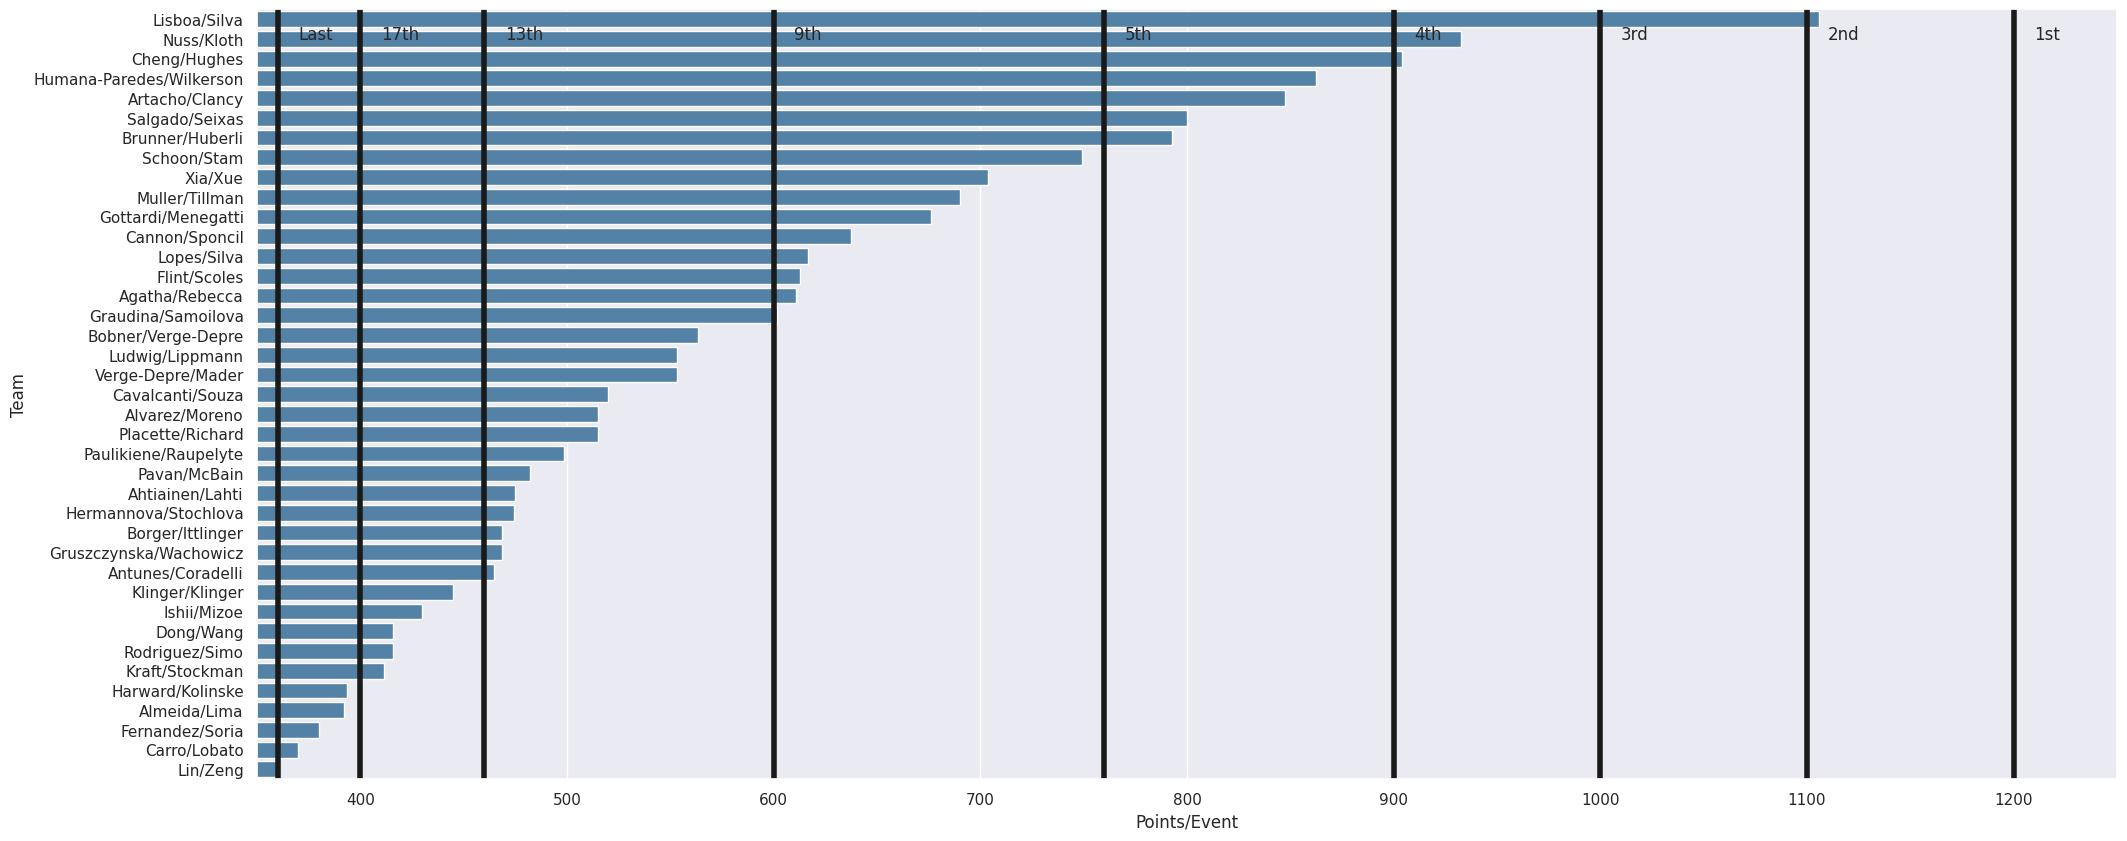

In [16]:
plot_ranks(df,gender='female')

In [17]:
import numpy as np
df.groupby(['Team','Date']).apply(lambda x: np.diff(x.Points))

Team            Date      
Agatha/Rebecca  2023-07-31    []
                2023-10-01    []
                2023-10-16    []
                2023-11-06    []
                2023-11-27    []
                              ..
Xia/Xue         2023-08-21    []
                2023-10-01    []
                2023-10-16    []
                2023-11-06    []
                2023-11-27    []
Length: 794, dtype: object